# Setup

## Importing and testing Environment

In [3]:
import sys

print(sys.version)

3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)]


In [57]:
import time

import os
import numpy as np

import tensorflow as tf 
from tensorflow import keras
#tf.config.set_per_process_memory_growth(True)

import pickle

import collections
from collections import defaultdict
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Embedding, Reshape, Activation
from keras.layers import Concatenate, Conv2DTranspose, multiply, UpSampling2D
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils import Progbar
from keras.metrics import *
from keras import backend as K

import cv2

### Test TensorFlow CUDA-Enabled

In [3]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num CPUs Available: ", len(tf.config.list_logical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPUs Available:  1
Num CPUs Available:  1
Num GPUs Available:  1


In [4]:
print(tf.__version__)

2.10.1


In [5]:
print(tf.test.is_built_with_cuda())
# True or False
print(tf.test.is_built_with_gpu_support())
# True or False
print(tf.test.is_built_with_rocm())
# True or False
print(tf.test.is_built_with_xla())
# True or False
print(tf.config.list_physical_devices(device_type='GPU'))
print(tf.config.list_logical_devices(device_type='GPU'))

True
True
False
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


# Data Loader

Check current dir

In [3]:
os.getcwd()

'd:\\Projects\\chest-xrays-classification-generation'

Set batch size, image size and path

In [195]:
batch_size=32
img_size=112


# set training, validation, and testing paths
training_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/train')
val_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/val')
testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/test')

ImageDataGenerator:
- The directory must be set to the path where your ‘n’ classes of folders are present.
- The target_size is the size of your input images, every image will be resized to this size.
- color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
- batch_size: No. of images to be yielded from the generator per batch.
- class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.
- shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
- seed: Random seed for applying random image augmentation and shuffling the order of the image.

In [196]:
# initialize training data generator with validation split and data augmentation
train_datagen = ImageDataGenerator(validation_split = 0.1, 
                                   shear_range=0.1, 
                                   zoom_range=0.1)
# initialize testing data generator with data augmentation
test_datagen = ImageDataGenerator(shear_range=0.1, 
                                  zoom_range=0.1)

# generate training data from training path with batch size and target size specified
train_data = train_datagen.flow_from_directory(training_path, subset='training', 
                                               batch_size = batch_size, 
                                               target_size = (img_size, img_size),
                                               shuffle = True, class_mode = 'binary', seed = 42)

# generate validation data from training path with batch size and target size specified
val_data = train_datagen.flow_from_directory(training_path, subset='validation', 
                                             batch_size = batch_size, 
                                             target_size = (img_size, img_size), 
                                             shuffle = True, class_mode = 'binary', seed = 42) 

# generate testing data from testing path with batch size and target size specified
test_data = test_datagen.flow_from_directory(testing_path, batch_size = batch_size, 
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 42)

# print class indices for binary classification
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)


# get the first batch of training data
batchX, batchy = train_data.next()
# print the shape of training batch and label batch
print('train_batch.shape:', batchX.shape)
print('label_batch.shape', batchy.shape)

Found 26465 images belonging to 3 classes.
Found 2939 images belonging to 3 classes.
Found 400 images belonging to 3 classes.
{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
train_batch.shape: (32, 112, 112, 3)
label_batch.shape (32,)


In [197]:
len(train_data) # batches per epoch for training

828

In [198]:
len(val_data) # batches per epoch for validation

92

In [199]:
len(test_data) # batches per epoch for testing

13

# Discriminator Model Architecture

**Discriminator Architecture Logic**:
1. The input to the discriminator is an image with dimensions 112 × 112 × 3.
   - The image could either come from the original dataset (Xreal) or be generated by the generator (X fake).
2. The discriminator consists of four blocks, each composed of a sequence of a convolutional layer, batch normalization layer, LeakyReLU activation with a slope of 0.2, and a dropout layer with a probability of 0.5. These blocks successively reduce the image size from 112 × 112 × 3 to 56 × 56 × 64, 28 × 28 × 128, 14 × 14 × 256, and finally 7 × 7 × 512.
3. The tensor is then flattened and fed into two dense layers that output the final results.
4. The first dense layer produces a 1D tensor with a sigmoid activation function. It acts as a binary classifier and outputs a probability indicating whether the image is from the original dataset (as "real") or generated by the generator (as "fake").
5. The second dense layer outputs a 2D tensor, produced by a softmax activation function, which acts as a classifier identifying the class of each input image.

In [7]:
def discriminator(input_shape=(112, 112, 3), n_classes = 3):
    # Define the weight initialization method
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
    
    # Define the convolutional block to be used multiple times
    def conv_block(input_layer, filter_size, stride):
        # Apply Conv2D with specified filter size, kernel size, padding, strides and weight initialization
        x = Conv2D(filter_size, kernel_size = (3,3), padding='same', 
                   strides=stride, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_layer)
        # Apply BatchNormalization with momentum = 0.9
        x = BatchNormalization(momentum = 0.9)(x)
        # Apply LeakyReLU activation with alpha = 0.2
        x = LeakyReLU(alpha = 0.2)(x)
        # Apply dropout with rate 0.5
        x = Dropout(0.5)(x)
        # Return the result
        return x
    
    # Input layer for image
    input_img = Input(shape=input_shape)
    
    # Apply Conv2D with 32 filters, kernel size (3, 3), strides (1, 1), padding 'same' and weight initialization
    x = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), padding='same', 
               kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_img)
    # Apply BatchNormalization with momentum = 0.9
    x = BatchNormalization(momentum = 0.9)(x)
    # Apply LeakyReLU activation with alpha = 0.2
    x = LeakyReLU(alpha = 0.2)(x)
    # Apply dropout with rate 0.5
    x = Dropout(0.5)(x)

    # Downsample the image to 56 x 56 x 64 using the conv_block
    x = conv_block(x, 64, (2, 2))
    # Downsample the image to 28 x 28 x 128 using the conv_block
    x = conv_block(x, 128, (2, 2))

    # Downsample the image to 14 x 14 x 256 using the conv_block
    x = conv_block(x, 256, (2, 2))
    # Downsample the image to 7 x 7 x 512 using the conv_block
    x = conv_block(x, 512, (2, 2))
    
    # Flatten the final layer
    features = Flatten()(x)

    # Binary classifier to classify image as fake or real
    fake = Dense(1, activation='sigmoid', name='source')(features)

    # Multi-class classifier to classify image digit
    aux = Dense(n_classes, activation='softmax', name='auxiliary')(features)

    # Create the final model
    # Model has two outputs - fake (binary fake/real prediction) and aux (multi-class digit prediction)
    model = Model(inputs = input_img,  outputs = [fake, aux])

    # Return the model
    return model

In [52]:
d = discriminator(input_shape=(112, 112, 3))
d.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 112, 112, 32  896         ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_64 (BatchN  (None, 112, 112, 32  128        ['conv2d_40[0][0]']              
 ormalization)                  )                                                          

# Generator Model Architecture

The generator takes a (latent_dim)-dimensional noise vector and an integer class label as input, producing a fake image of dimension 112x112x3 as output.

**Generator Architecture Logic**:
1. The generator takes two inputs: a 50-dimensional noise vector z, which is randomly generated from a normal distribution with a mean of 0 and a standard deviation of 0.02, and an integer class label c.
2. The class label is first transformed through a 50-dimensional embedding layer and then a dense layer with 7 × 7 units, producing a 7 × 7 × 1 tensor. The noise vector is processed by a dense layer with 1024 × 7 × 7 units to produce a 7 × 7 × 1024 tensor.
3. These two tensors are then combined to form a 7 × 7 × 1025 tensor.
4. This is followed by four consecutive transposed convolutional layers, increasing the size of the tensor to 14 × 14 × 512, 28 × 28 × 256, 56 × 56 × 128, and finally 128 × 128 × 3
   -  The kernel size for the transposed convolutions is 5 and the stride is 2.
   -  Each transposed convolution is paired with batch normalization and a Rectified Linear Unit (ReLU) activation, except for the last one, which uses tanh activation.
5. The final output from the generator is a fake image X with dimensions 112 × 112 × 3.

In [8]:
def generator(latent_dim = 100, n_classes = 3):
    # Initialize RandomNormal with mean = 0.0 and stddev = 0.02
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
  
    ### Input 1: class label input ###
    
    # Generator take integer class label as input
    label_input = Input(shape = (1,))
    # print(label_input.shape)
    
    # Embedding layer: to convert class label integer to a vector of size 100
    y = Embedding(n_classes, 100)(label_input)
    # print('Embedding Layer: ', y.shape)
    
    # Dense layer with 7 x 7 units: to convert the vector to a 7 x 7 x 1 tensor
    n_nodes = 7 * 7
    y = Dense(n_nodes, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(y)
    # print('Dense 1: ', y.shape)
    y = Reshape((7, 7 ,1))(y)
    print('reshape(final y shape): ', y.shape)

    ### Input 2: generator noise input ###
    
    # A latent_dim-dimensional vector is sampled from a normal distribution
    # with mean = 0.0 and stddev = 0.02 
    generator_input = Input(shape = (latent_dim,))
    
    # Noise vector is passed through a dense layer with 1024 * 7 * 7 units 
    # to produce a 7 x 7 x 1024 tensor
    n_nodes = 1024 * 7 * 7
    gen = Dense(n_nodes, 
                kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(generator_input)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 1024))(gen)
    print('Generator noise input: ', gen.shape)
    
    ### Concatenate both the inputs ###
    # The output tensors are then concatenated to produce a 7 × 7 × 1025 tensor. 
    merge = Concatenate()([gen, y])
    print('Concatenate(generator noise input and y: ', merge.shape)

    ### Upsampling ###
    # four successive transposed convolutions 
    # to produce tensors with dimensions 14 × 14 × 512, 28 × 28 × 256, 56 × 56 × 128 and 128 × 128 × 3, respectively.
    
    # (None, 7, 7, 1024) --> (None, 14, 14, 512)
    gen = Conv2DTranspose(512, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(merge)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print("(None, 7, 7, 1024) -> (None, 14, 14, 512): ", gen.shape)

    # (None, 14, 14, 512)  --> (None, 28, 28, 256)
    gen = Conv2DTranspose(256, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 14, 14, 512) -> (None, 28, 28, 256): ', gen.shape)

    # (None, 28, 28, 256) --> (None, 56, 56, 128)
    gen = Conv2DTranspose(128, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 28, 28, 256) -> (None, 56, 56, 128): ', gen.shape)

    # (None, 56, 56, 128) --> (None, 112, 112, 3)
    gen = Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    out_layer = Activation("tanh")(gen)
    print("(None, 56, 56, 128) -> (None, 112, 112, 3): ", out_layer.shape)
    
    # The final output from the generator is an fake image X of dimension 112 × 112 × 3
    model = Model(inputs = [generator_input, label_input], outputs = out_layer)
    return model

In [25]:
g = generator(latent_dim = 100, n_classes = 3)
g.summary()

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                    

# AC-cGAN model architecture

**AC-cGAN Architecture Logic**
Following code defines a Generative Adversarial Network with an additional auxiliary classifier. (AC-cGAN)
The generator and the discriminator are compiled using the Adam optimizer with specified learning rate and beta_1 value. The generator takes as input a latent noise vector and an image class, and outputs a generated fake image. The discriminator takes as input an image and outputs a binary decision on whether it's real or fake, and an auxiliary class prediction. The combined model connects the generator and the discriminator, and when trained, the generator will learn to generate fake images that the discriminator cannot distinguish from real ones.

**Loss functions for discriminator**
- `binary_crossentropy` for fake/real classification
- `sparse_categorical_crossentropy` for multi-label classification (classes are mutually exclusive, sparse cte is less time and memeory consuming than categorical_crossentropy)

Definisco inoltre due metriche aggiuntive
- **binary accuracy fake** -> accuratezza nel predire correttamente immagini fake
- **binary accuracy true** -> accuratezza nel predire correttamente immagini vere

In [53]:
#adam_lr = 0.0002
#adam_beta_1 = 0.5

def define_acgan(latent_dim = 100, adam_lr = 0.0002, adam_beta_1 = 0.5):
    """
    This function defines and compiles the discriminator, generator, and combined models for a GAN.
    The models are compiled with the Adam optimizer, using the defined learning rate and beta 1 values.
    
    Parameters:
    latent_dim (int, optional): The dimension of the latent space that will be used as input to the generator.
    
    Returns:
    combined (Model): The combined generator and discriminator model.
    dis (Model): The discriminator model.
    gen (Model): The generator model.
    """
    
    ### STEP1: Define and train/evaluate the DISCRIMINATOR model ###
    
    # Define the discriminator model and Adam optimizer \
        # with the defined learning rate and beta 1 values and \
            # loss function as binary crossentropy and sparse categorical crossentropy
    dis = discriminator()
    # dis.summary()
    # We define two losses, the first for the real/fake binary output and the second for the class label output
    dis.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss={'source':'binary_crossentropy', 'auxiliary':'sparse_categorical_crossentropy'}
        # , metrics = {'source':BinaryAccuracy(threshold=.5), 'auxiliary':'sparse_categorical_accuracy'}
    )

    ### STEP2: Define and input the GENERATOR model ###
    
    # Define the generator model
    gen = generator(latent_dim)
    # gen.summary()
    # Compile the discriminator model with the Adam optimizer, \
        # using binary crossentropy and sparse categorical crossentropy as loss functions
    
    # We will note use this function to train/evaluate the generator model
    # but we will use combined model with the discriminator model disabled
    # to train and evaluate the generator model
    gen.compile(optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy')

    # Define inputs for the generator model (noise vector and image class)
    latent = Input(shape=(latent_dim, ), name='latent_noise')
    image_class = Input(shape=(1,), name='image_class')
    print(image_class.dtype)
    # Get a fake image
    fake_img = gen([latent, image_class])
    print('fake image: ', fake_img.shape)
    
    ### STEP3: Train/evaluate the GENERATOR model by using the COMBINED model with the DISCRIMINATOR model disabled ###
    
    # Disable training of the discriminator model in the combined model
    dis.trainable = False
    
    # Get the fake and auxiliary classes outputs from the discriminator model, \ 
    # using the generated fake image as input
    fake, aux = dis(fake_img) 
    
    # Define the combined model, which takes the noise vector and image class as input, \
        # and outputs the fake and auxiliary classes
    combined = Model(inputs=[latent, image_class],
                            outputs=[fake, aux],
                            name='ACGAN')

    # Function used to train/test the generator model
    combined.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    
    combined.summary()
    
    # Return the combined model, discriminator model, and generator model
    return combined, dis, gen

In [33]:
accgan_model = define_acgan(latent_dim=100)

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
<dtype: 'float32'>
fake image:  (None, 112, 112, 3)
Model: "ACGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_noise (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 image_class (InputLayer)       [(None, 1)]          0           []                               
                                  

# AC-cGAN Training

## Tools

**Label Smoothing**: The initial labels are represented by "L" and the smoothed labels are represented by "Ls." The function "Rand," which generates a random number between 0 and 1, is used as the pseudo-random number generator. The scaling factor "MaxDev" adjusts the random number so that it ranges from 0 to the specified value of "MaxDev".
Label smoothing replaces the strict label assignments with more relaxed ones, it serves as a regularization method that improves the generalization capability and performance of models.

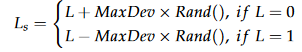

In the specific case, label smoothing is applied to fake (0 label) and real (1 label) labels

In [10]:
# Label smoothing function which adds a small random value to the labels
# and we will use this function to smooth the binary labels for the discriminator
def label_smoothing(vector, max_dev = 0.2):
        d = max_dev * np.random.rand(vector.shape[0],vector.shape[1])
        if vector[0][0] == 0:
            return vector + d
        else:
            return vector - d
          
# valid_o = np.ones((batch_size, 1))
# fake_o = np.zeros((batch_size, 1))

# --------------------- #

# Function for printing accuracy logs after every epoch
# This function prints the accuracy of the generator and discriminator models

def print_logs(metrics_names, train_history, test_history):

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

# Function to generate a batch of noise and label 

def generate_batch_noise_and_labels(batch_size, latent_dim, n_classes = 3):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # sample some labels
    sampled_labels = np.random.randint(0, n_classes, batch_size)

    return noise, sampled_labels

**IMAGE GERATOR for gif**

The function below generates a 4x4 set of images, given:
- the generator model
- The current epoch
- A seed of 16 noise vectors
- A seed of 16 associated labels

The operation requires that:
1. You define a seed, which will remain unchanged so that you always have the same labels

In [178]:
seed_gif_noise, seed_gif_labels = generate_batch_noise_and_labels(batch_size=16, latent_dim=100)

2. Check that the seed is eterogeneous enough

In [179]:
print(seed_gif_labels)

[2 0 1 1 0 2 0 1 2 2 1 0 0 0 1 1]


3. Use the function during training

In [188]:
def generate_and_save_images(model, epoch, noise, labels):
  name_map = {0:'COVID-19', 1:'normal', 2:'pneumonia'}
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  generated_images_sample = gen.predict([noise, labels.reshape((-1, 1))], verbose=0)
  norm_image = cv2.normalize((generated_images_sample + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  norm_img = norm_image.astype(np.uint8)

  fig = plt.figure(figsize=(10, 10))

  for i in range(norm_img.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.title(name_map[labels[i]])
      plt.imshow(norm_img[i,:,:], cmap='gray')
      plt.axis('off')

  plt.savefig('./AC-cGAN/images_for_gif/image_at_epoch_{:04d}.png'.format(epoch))

## Training

## **TRAINING/TESTING Pipelone** and **METRICS**

**DISCRIMINATOR training**

First of all discrimitator is trained/evaluated on how good it recnognize fake/real sample and class labels. 

In particular:
1. A batch (batch_size dimensional) of pairs of noise vectors and classes is passed to the generator, which generates batch_size fake images with corresponding class.
2. We extract batch_size real image/class label pairs from the dataset
3. The fake and real images are concatenated to form sets of 2*batch_size images. For each image will be associated 
   - a binary label (0,1) indicating whether they are fake or real, which are then **smoothed**
   - a class (integer 0,1,2) 
4. This set is sent to the discriminator, which classifies:
   - Binary classifier for real fakes
   - Single label multi class classifier
5. Evaluation metrics are calculated for the two classifiers
   1. **Source Loss**: loss related to the model's ability to recognise fake/real (which we want to be **minimized**)
      
      
   2. **Auxiliary Class Loss**: loss related to the model's ability to recognise correct class(which we want to be **minimized**)
      
      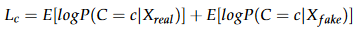
   3. **Loss**: **Source Loss** + **Class Loss** (which we want to be **minimized**)

      
6. Discriminator weights are updated to maximixe source loss
   

**DISCRIMINATOR METRICS** 

Losses:

- **loss**: generation (binary_crossentropy) loss + auxiliary classifier loss (sparse categorical crossentropy)
- **source loss (real/fake classifier)** -> binary crossentropy
- **auxiliary loss (label class classifier)** -> sparse categorical crossentropy
  - We use sparse categorical crossentropy so we can use integer labels as `[0,1,2,1,0,1]` instead of one-hot encoding like `[[1,0,0], [0,1,0] ...]`

Additional metrics
- **source binary accuracy** -> binary_accuracy (real/fake classifier accuracy)
- **auxiliary loss (label class classifier)** -> sparse categorical accuracy

In [48]:
dis.metrics_names

[]

**GENERATOR training**

Then we train/evaluate generator, by evaluating the combined model with freezed discriminator. Again, the generator metrics are obtained from the discriminator.
1. We define the combined model and freeze the discriminator
2. A batch (batch_size*2 dimensional) of pairs of noise vectors and classes is passed to the generator, which generates batch_size*2 fake images with corresponding class.
3. For each image will be associated 
   - **TRICK**: all fake images are associated with label 1 (real), even though they are all fakes (so they should have label 0), in order to 'trick' the discriminator. The reason is explained by the metrics. 
   - a class (integer 0,1,2) 
4. This set is sent to the discriminator, which classifies:
   - Binary classifier for real fakes (with tricked binary labels)
   - Single label multi class classifier
5. Evaluation metrics are calculated for the two classifiers,defining the generator loss
   1. **Source Loss**: loss related to the model's ability to recognise fake/real (which we want to be **MAXIMIZE**) !!!
      
      ![source_loss.png](Altro/Images/source_loss.png)
   2. **Auxiliary Class Loss**: loss related to the model's ability to recognise correct class(which we want to be **MINIMIZE**)
      
      ![class_loss.png](Altro/Images/class_loss.png)
   3. **Loss** = **Class Loss** - **Source Loss** (which we want to be **MINIMIZE**)

      ![generator_loss.png](Altro/Images/generator_loss.png)
      - Here the role of the **trick** becomes important, to obtain the inverse of Ls, we go to the discriminator (to the binary classifier) label WRONG. That is, we pass a list of label 1 (real) when all images are in fact fake.

**Generator Metrics**:
- `loss`: $L = L_c - L_s$ (MINIMIZE)
- `binary_crossentropy`: $-L_s$ biinary discriminator classifier for fake/real for tricked labels (MINIMIZE)
- `sparse_categorical_crossentropy`: $L_c$ multi class single label classifier loss (minimez)

In [43]:
combined.metrics_names

['loss', 'model_12_loss', 'model_12_1_loss']

**Training Hyperparameters**

In [182]:
nb_epochs = 1200
batch_size = batch_size
latent_dim = 100
nb_batches_train = len(train_data) # number of iterarions per epoch for training
nb_batches_test = len(test_data) # number of iterarions per epoch for testing
nb_batches_val = len(val_data) # number of iterarions per epoch for validation

save_every_n_epoch = 20 # save the model and history every n epochs
save_images_every_n_epoch = 10

print('Number of epochs: ', nb_epochs)
print('Batch size: ', batch_size)
print('Number of batches per epoch for training: ', nb_batches_train)
print('Number of batches per epoch for testing: ', nb_batches_test)


train_history = defaultdict(list)
test_history = defaultdict(list)
test_accuracy_history = defaultdict(list)

Number of epochs:  1200
Batch size:  64
Number of batches per epoch for training:  414
Number of batches per epoch for testing:  7


**Define AC-cGAN**

In [180]:
combined, dis, gen = define_acgan(latent_dim = latent_dim)

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
<dtype: 'float32'>
fake image:  (None, 112, 112, 3)
Model: "ACGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_noise (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 image_class (InputLayer)       [(None, 1)]          0           []                               
                                  

**TRAINING**

Epoch 1 of 1200, training ..
1/1 [==============================] - 1s 680ms/step

Testing for epoch 1:
7/7 [==============================] - 6s 950ms/step
component              | loss | source_loss     | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.29 | 1.44            | 1.85 
generator (test)       | 3.41 | 1.32            | 2.09 
discriminator (train)  | 1.78 | 0.61            | 1.17 
discriminator (test)   | 2.64 | 0.78            | 1.86 
Test Disc Accuracy of the real images: 0.0
Test Disc Accuracy of the fake images: 1.0
Epoch 2 of 1200, training ..
1/1 [==============================] - 1s 607ms/step

Testing for epoch 2:
7/7 [==============================] - 5s 747ms/step
component              | loss | source_loss     | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 3.33 | 1.37            | 1.96 
generator (test)       | 3.15 | 1.12            | 2.03 
di

KeyboardInterrupt: 

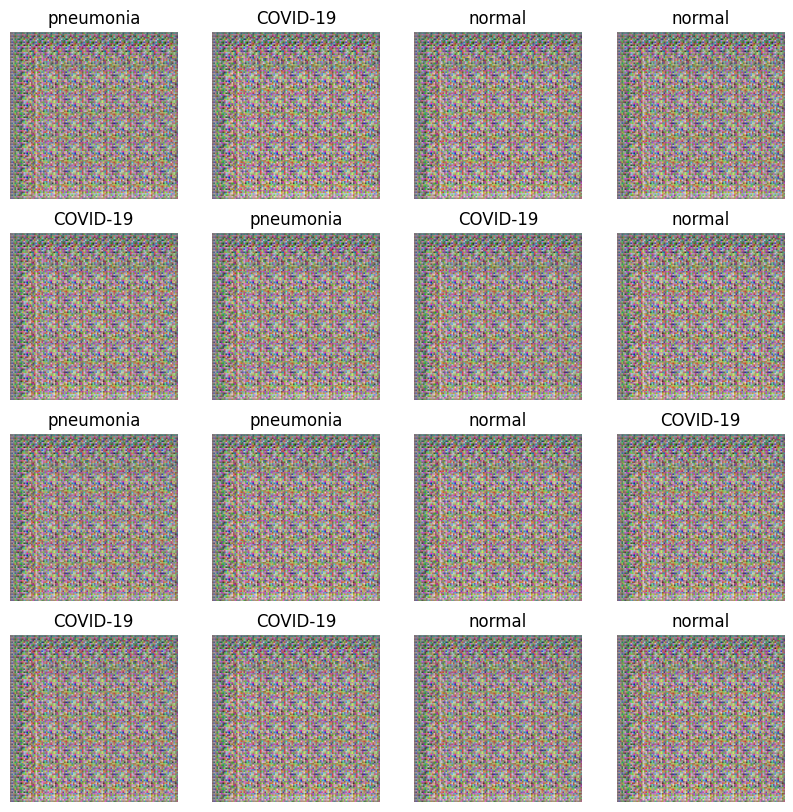

In [190]:
nb_batches_train = 1
for epoch in range(nb_epochs):
    # Epochs counter
    print('Epoch {} of {}, training ..'.format(epoch + 1, nb_epochs))

    # Number of batches per epoch for training to display the progress bar
    # nb_batches = nb_batches_train # int(1332/batch_size)
    progress_bar = Progbar(target=nb_batches_train)

    # Lists for keeping track of the loss and accuracy of the generator and discriminator
    epoch_gen_loss = []
    epoch_disc_loss = []
    gen_test_loss = []
    disc_test_loss = []
    disc_real_accuracy = []
    disc_fake_accuracy = []

    # Iterate over the batches of the training dataset
    for index, (image_batch, label_batch) in zip(range(nb_batches_train), train_data):
        
        # NORMALIZE the image batch to the range [-1, 1]
        image_batch = image_batch * (1. / 127.5) - 1

        # Get the batch size (not always flow_from_directory returns a batch of size batch_size)
        # which is the case for the last batch of the epoch when the number of images is not divisible by batch_size
        nb_train = image_batch.shape[0]
        
        # Update progress bar
        progress_bar.update(index+1)
        
        ### TRAIN the DISCRIMINATOR ###
        
        # Generate a batch of noise and labels for the generator of nb_train samples
        noise, sampled_labels = generate_batch_noise_and_labels(nb_train, latent_dim)
        # Generate a batch of fake images
        generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))],  verbose=0)
        
        # Concatenate the real and fake images
        X = np.concatenate((image_batch, generated_images))
        
        # Smoothed real/fake binary labels for the discriminator (real images ~ 1, fake images ~ 0)
        valid = label_smoothing(vector = np.ones((nb_train, 1)), max_dev = 0.2)
        fake = label_smoothing(vector = np.zeros((nb_train, 1)), max_dev = 0.2)
        #valid = np.ones((nb_train, 1))
        #fake = np.zeros((nb_train, 1))
        # Concatenate the labels for the real and fake images
        y = np.concatenate((valid, fake), axis = 0)
        
        # Concatenate class labels for the real images and the fake images [0, 1, 2, 0, 1, 2, 0, 1, 2, ...]
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)
        
        # TRAIN the DISCRIMINATOR on the real and fake images (with corresponding y fake/real and aux_y class labels)
        # and append TRAINING DISCRIMINATOR LOSS
        epoch_disc_loss.append(dis.train_on_batch(X, [y, aux_y]))
        
        ### TRAIN the GENERATOR ###
        
        # Generate a batch of noise and labels for the generator of 2*nb_train samples
        noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_train, latent_dim)
        
        # Trick the discriminator into thinking that the generated samples are real
        # by using the valid labels (1) as target for the discriminator
        trick = np.ones(2 * nb_train)
        
        # TRAIN the GENERATOR (discriminator parameters are frozen)
        # and appen TRAINING GENERATOR LOSS
        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))
        # print(combined.train_on_batch(
        #     [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))
    
    # Iterate over the batches of the validation dataset
    # Initialize the progress bar
    progress_bar = Progbar(target=nb_batches_test)
    
    print('\nTesting for epoch {}:'.format(epoch + 1))
    
    for index_1, (test_image_batch, test_label_batch) in zip(range(nb_batches_test), test_data):        
        # Update progress bar
        progress_bar.update(index_1+1)
        
        # NORMALIZE the image batch to the range [-1, 1]
        test_image_batch = test_image_batch * (1. / 127.5) - 1

        # Get the batch size (not always flow_from_directory returns a batch of size batch_size)
        nb_test = test_image_batch.shape[0]
        
        # Generate a batch of noise and labels for the generator of nb_test samples
        noise, sampled_labels = generate_batch_noise_and_labels(nb_test, latent_dim)

        # Generate a batch of fake images
        generated_images = gen.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False
        )  
        
        # Concatenate the real and fake images
        X = np.concatenate((test_image_batch, generated_images))
        # Concatenate the binary labels for the real and fake images
        y = np.array([1] * nb_test + [0] * nb_test)
        # Concatenate the class labels for the real and fake images
        aux_y = np.concatenate((test_label_batch, sampled_labels), axis=0)
        
        # TEST the DISCRIMINATOR on the real and fake images (with corresponding y fake/real and aux_y class labels)
        test_discriminator_loss = dis.evaluate(X, [y, aux_y], verbose = False)
        # Generate separate ACCURACY metrics for real and fake images
        disc_pred = dis.predict(X, verbose = False)
        acc_real = tf.reduce_mean(tf.cast(K.equal(y[:nb_test], K.round(K.clip(disc_pred[0][:nb_test], 0, 1))), tf.float32)).numpy()
        acc_fake = tf.reduce_mean(tf.cast(K.equal(y[nb_test:], K.round(K.clip(disc_pred[0][nb_test:], 0, 1))), tf.float32)).numpy()
        
        disc_real_accuracy.append(acc_real)
        disc_fake_accuracy.append(acc_fake)
        
        # DISCRIMINATOR TEST LOSS: Append the discriminator loss to the test list
        disc_test_loss.append(test_discriminator_loss)

        # TEST the GENERATOR
        # Generate a batch of noise and labels for the generator of 2*nb_test samples
        noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_test, latent_dim)
        # Trick the discriminator into thinking that the generated samples are real
        trick = np.ones(2 * nb_test)
        # TEST the GENERATOR 
        test_generator_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose = False
        )
        # GENERATOR TEST LOSS: Append the generator loss to the test list
        gen_test_loss.append(test_generator_loss)

        # break

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    generator_test_loss = np.mean(np.array(gen_test_loss), axis=0)

    discriminator_test_loss = np.mean(np.array(disc_test_loss), axis=0)
    
    discriminator_test_accuracy_real = np.mean(np.array(disc_real_accuracy), axis=0)
    discriminator_test_accuracy_fake = np.mean(np.array(disc_fake_accuracy), axis=0)

    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    
    test_accuracy_history['discriminator_real'].append(discriminator_test_accuracy_real)
    test_accuracy_history['discriminator_fake'].append(discriminator_test_accuracy_fake)

    print_logs(dis.metrics_names, train_history, test_history)
    print(f'Test Disc Accuracy of the real images: {discriminator_test_accuracy_real}')
    print(f'Test Disc Accuracy of the fake images: {discriminator_test_accuracy_fake}')
    
    # Save the weights, history and images every save_every_n_epoch epochs
    if (epoch+1) % save_every_n_epoch == 0: 
        gen.save_weights(
            './AC-cGAN/parameters/params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        dis.save_weights(
            './AC-cGAN/parameters/params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)
        pickle.dump({'train': train_history, 'test':test_history},
            open('./AC-cGAN/weights/acgan_history_{0:03d}.pkl.format(epoch)', 'wb'))
    
    # Images generated every save_every_n_epoch epochs
    if ((epoch+1) % save_every_n_epoch == 0) or (epoch == 0): 
        generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels) 

gen.save_weights(
    f'./AC-cGAN/parameters/params_generator_epoch_{nb_epochs}.hdf5', True)
dis.save_weights(
    f'./AC-cGAN/parameters/params_discriminator_epoch_{nb_epochs}.hdf5', True)
pickle.dump({'train': train_history, 'test':test_history},
    open(f'./AC-cGAN/weights/acgan_history_{nb_epochs}.pkl', 'wb'))
generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels)

# Image Generation

In [173]:
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed_gif_noise, seed_gif_labels = generate_batch_noise_and_labels(batch_size=16, latent_dim=100)

def generate_and_save_images(model, epoch, noise, labels):
  name_map = {0:'COVID-19', 1:'normal', 2:'pneumonia'}
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  generated_images_sample = gen.predict([noise, labels.reshape((-1, 1))], verbose=0)
  norm_image = cv2.normalize((generated_images_sample + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  norm_img = norm_image.astype(np.uint8)

  fig = plt.figure(figsize=(10, 10))

  for i in range(norm_img.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.title(name_map[labels[i]])
      plt.imshow(norm_img[i,:,:], cmap='gray')
      plt.axis('off')

  plt.savefig('./AC-cGAN/images_for_gif/image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()

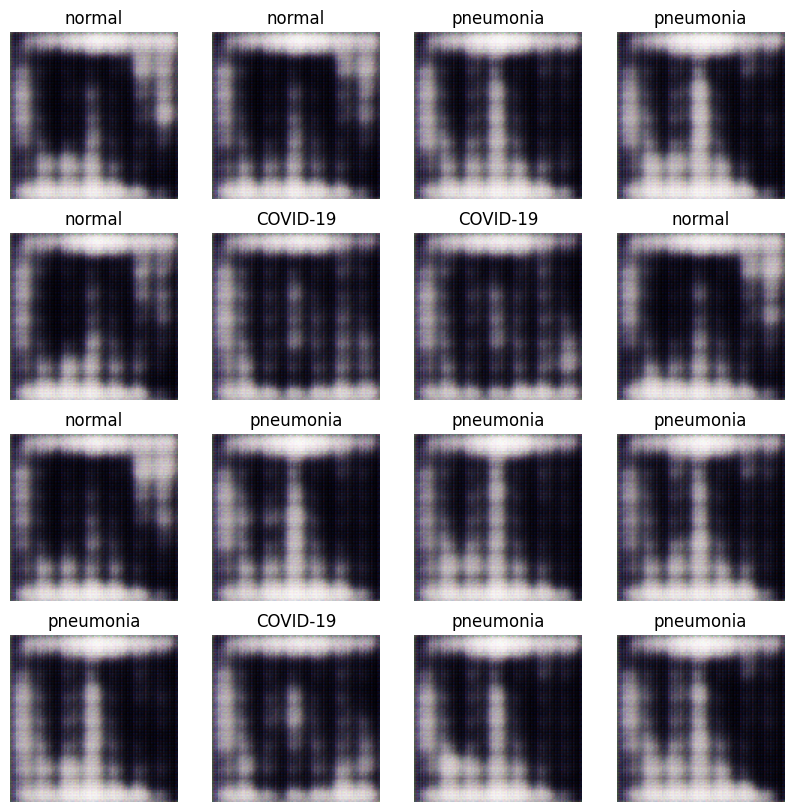

In [175]:
generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels)

(112, 112, 3)
normal


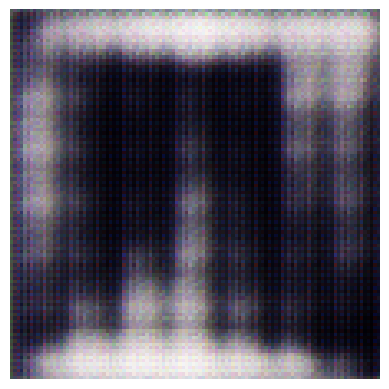

(112, 112, 3)
COVID-19


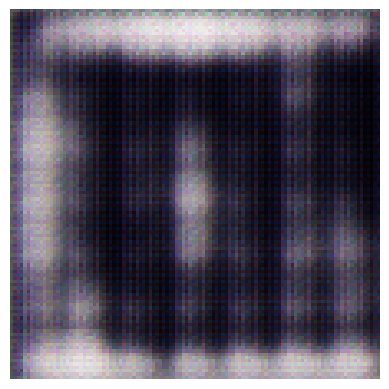

KeyboardInterrupt: 

In [162]:
name_map = {0:'COVID-19', 1:'normal', 2:'pneumonia'}

noise_gen, sampled_labels_gen = generate_batch_noise_and_labels(batch_size=62, latent_dim=100)
generated_images_sample = gen.predict([noise_gen, sampled_labels_gen.reshape((-1, 1))], verbose=0)

norm_image = cv2.normalize((generated_images_sample + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
norm_img = norm_image.astype(np.uint8)
for i in range(len(norm_img)):
    plt.figure()
    img = norm_img[i,:,:]
    print(img.shape)
    print(name_map[sampled_labels_gen[i]])
    plt.imshow(img, cmap='gray')
    _ = plt.axis('off')
    plt.savefig('image.png')
    plt.show()
    time.sleep(5)

# img = norm_img[0,:,:]
# print(img.shape)
# # img = (np.concatenate([r.reshape(-1, 112)
# #                        for r in np.split(generated_images, 2)
# #                        ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

# # plot images
# plt.imshow(img, cmap='gray')
# _ = plt.axis('off')